# NLP tutorial with tensorflow

# Tokenisation

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'i love my dog',
    'I, love my cat',
    'You love my dog!'
]

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'love': 1, 'my': 2, 'i': 3, 'dog': 4, 'cat': 5, 'you': 6}


# Text to sequence & Padding

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=5)
print("\nWord Index = " , word_index)
print("\nSequences = " , sequences)
print("\nPadded Sequences:")
print(padded)


# Try with words that the tokenizer wasn't fit to
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print("\nTest Sequence = ", test_seq)

padded = pad_sequences(test_seq, maxlen=10)
print("\nPadded Test Sequence: ")
print(padded)


Word Index =  {'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}

Sequences =  [[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]

Padded Sequences:
[[ 0  5  3  2  4]
 [ 0  5  3  2  7]
 [ 0  6  3  2  4]
 [ 9  2  4 10 11]]

Test Sequence =  [[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]

Padded Test Sequence: 
[[0 0 0 0 0 5 1 3 2 4]
 [0 0 0 0 0 2 4 1 2 1]]


# Build the model

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
import json
import zipfile
import os


def download_kaggle_json_dataset(dataset, filename, path="./", username=None, key=None, return_data=True):
    if username or key:
        os.environ['KAGGLE_USERNAME'] = username
        os.environ['KAGGLE_KEY'] = key
        
    api = KaggleApi()
    api.authenticate()
    print("Downloading..")
    api.dataset_download_file(dataset_name, file_name, path=path)

    zip_path = os.path.join(path, f'{file_name}.zip')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(path)
    os.remove(zip_path)

    if return_data:
        json_path = os.path.join(path, file_name)
        with open(json_path, 'r') as file:
            data = json.load(file)
        return data

In [6]:
dataset_name = 'rmisra/news-headlines-dataset-for-sarcasm-detection'
file_name = 'Sarcasm_Headlines_Dataset_v2.json'
path = "./datasets/"

# data = download_kaggle_json_dataset(dataset_name, file_name, path)

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [7]:
data = []
with open(os.path.join(path, file_name), 'r') as file:
    for line in file:
        data.append(json.loads(line))
sentences = []
labels = []
for item in data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [8]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [9]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
num_epochs = 30
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Epoch 1/30
625/625 - 4s - 7ms/step - accuracy: 0.5677 - loss: 0.6784 - val_accuracy: 0.6226 - val_loss: 0.6271
Epoch 2/30
625/625 - 2s - 3ms/step - accuracy: 0.7675 - loss: 0.5143 - val_accuracy: 0.7996 - val_loss: 0.4377
Epoch 3/30
625/625 - 2s - 3ms/step - accuracy: 0.8219 - loss: 0.4053 - val_accuracy: 0.8155 - val_loss: 0.4022
Epoch 4/30
625/625 - 2s - 3ms/step - accuracy: 0.8480 - loss: 0.3559 - val_accuracy: 0.8369 - val_loss: 0.3664
Epoch 5/30
625/625 - 2s - 3ms/step - accuracy: 0.8724 - loss: 0.3136 - val_accuracy: 0.8404 - val_loss: 0.3576
Epoch 6/30
625/625 - 2s - 3ms/step - accuracy: 0.8803 - loss: 0.2894 - val_accuracy: 0.8473 - val_loss: 0.3479
Epoch 7/30
625/625 - 2s - 3ms/step - accuracy: 0.8929 - loss: 0.2650 - val_accuracy: 0.8502 - val_loss: 0.3396
Epoch 8/30
625/625 - 2s - 3ms/step - accuracy: 0.9002 - loss: 0.2444 - val_accuracy: 0.8139 - val_loss: 0.4210
Epoch 9/30
625/625 - 2s - 3ms/step - accuracy: 0.9070 - loss: 0.2290 - val_accuracy: 0.8535 - val_loss: 0.3374
E

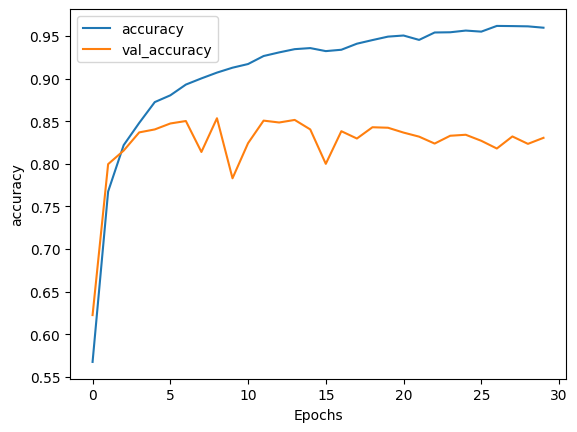

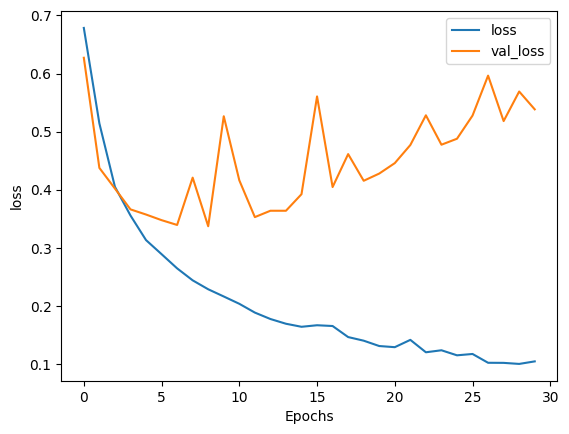

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

<OOV> scientists unveil doomsday clock of hair loss ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
eat your veggies: 9 deliciously different recipes
0


In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [17]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
[[0.74701726]
 [0.00161248]]


# End